In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse

pd.set_option('mode.chained_assignment', None)

def str_url_format(word):
    """
    Article name preprocessing.
    
    Apply this function any time a new dataframe is loaded.
    """
    return (urllib.parse.unquote(word)
            .replace("_", " ")
            .strip()
            .lower())
    
# Graph is defined in file `links.tsv`
df_links = (pd.read_csv("wikispeedia/wikispeedia_paths-and-graph/links.tsv", 
                        skiprows=12, 
                        sep="\t", 
                        header=None)
            .applymap(str_url_format)
            .rename(columns={0:"src",
                             1:"tgt"})
           )

df_links.sample(5)

,src,tgt
46216,great moravia,slovakia
56755,israel,azerbaijan
69033,mallard,park
41619,frog,vertebrate
49773,history of buddhism,korea


# Describe some general features of the network.

In [8]:
print(f"There are {df_links.shape[0]} edges")
print(f"connecting {df_links.stack().nunique()} unique nodes in the network.")
print(f"\n\t * {df_links['src'].nunique()} nodes have out-links.")
print(f"\t * {df_links['tgt'].nunique()} nodes have in-links.\n")

print(f"This means {df_links.stack().nunique() - df_links['src'].nunique()} nodes are dead-ends (no out-links),")
print(f"and {df_links.stack().nunique() - df_links['tgt'].nunique()} \
nodes can never be reached from any other article (no in-links) ☠️")

There are 119882 edges
connecting 4592 unique nodes in the network.

	 * 4587 nodes have out-links.
	 * 4135 nodes have in-links.

This means 5 nodes are dead-ends (no out-links),
and 457 nodes can never be reached from any other article (no in-links) ☠️


In [9]:
# nodes with no outlink (dead-ends)
nodes_no_outlink = (set(df.stack()
                        .unique())
                    .difference(df['src']
                                .unique()))
print(len(nodes_no_outlink))
nodes_no_outlink

5


{'directdebit',
 'duchenne muscular dystrophy',
 "klinefelter's syndrome",
 'local community',
 'osteomalacia'}

In [10]:
# Let's see which articles can't be reached from any other
nodes_no_inlink = list((set(df.stack()
                            .unique())
                        .difference(df['tgt']
                                    .unique())))
print(len(nodes_no_inlink))

nodes_no_inlink[:5]

457


['cleopatra vii of egypt',
 'indian institutes of technology',
 'nigella',
 'weyto language',
 'katyn massacre']

### All these nodes can only be visited if they're selected as starting point.

---

# Describe each node.

- in-degree: How many links point to article A?
- out-degree: How many articles can be reached directly from article A?

In [12]:
freq_out = df_links['src'].value_counts()
freq_in = df_links['tgt'].value_counts()

degree_freq = (pd.merge(freq_in,
                        freq_out, 
                        left_index=True, 
                        right_index=True, 
                        how='outer')
               .fillna(0)
               .rename(columns={"src":"out",
                                "tgt":"in"}))

degree_freq.head()

,in,out
1 ceres,12.0,32.0
10th century,65.0,26.0
11th century,57.0,48.0
12th century,85.0,45.0
13th century,84.0,34.0


# Check the distributions of in- and out-degree.

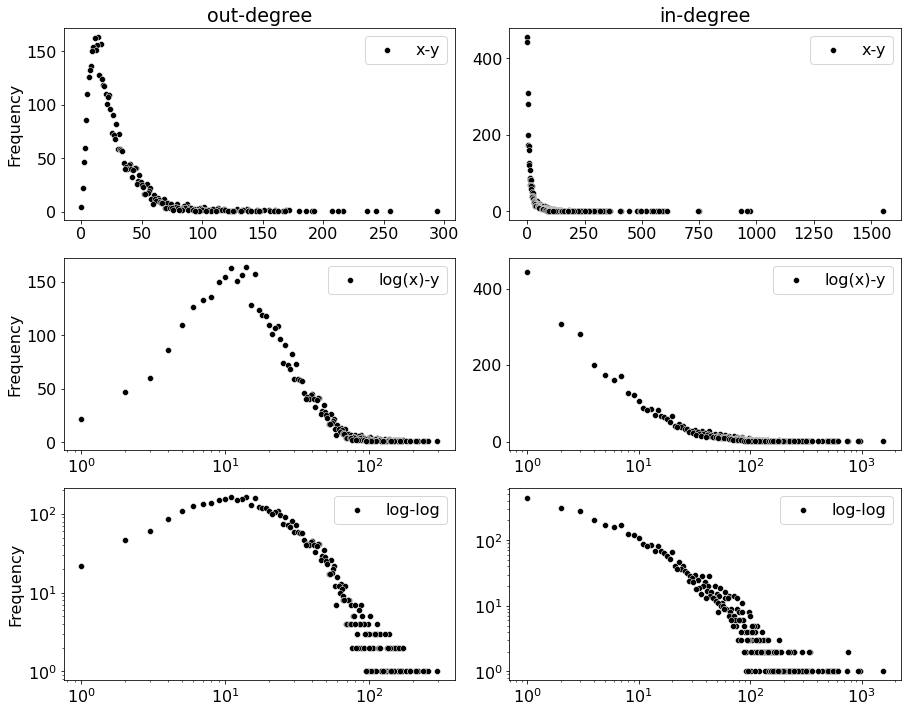

In [22]:
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(3,2,
                       figsize=(15,12),
                       gridspec_kw={'wspace':0.14})

labels = ["x-y", "log(x)-y", "log-log"]
for i in range(3):
    sns.scatterplot(data = (degree_freq['out']
                            .value_counts()), 
                    ax=ax[i,0], 
                    color='k', 
                    label=labels[i])
    sns.scatterplot(data = (degree_freq['in']
                            .value_counts()), 
                    ax=ax[i,1], 
                    color='k', 
                    label=labels[i])

ax[0, 0].set_title("out-degree")
ax[0, 1].set_title("in-degree")

for i in range(2):
    # Set log scale in x for second row plots
    ax[1,i].set_xscale('log')
    # log-log scale in 3rd row
    ax[2,i].set_xscale('log')
    ax[2,i].set_yscale('log')
    
for i in range(3):
    ax[i, 0].set_ylabel("Frequency")
    ax[i, 1].set_ylabel("")
    
plt.legend();

### Distributions of in- and out- degree are very different.

- in-degree distribution is more power-law-like. The lowest the in-degree, the higher frequency.
- out-degree has a more likely value of around 15.

---

# Now let's see the clicking frequency of articles, in actual paths players took.

In [23]:
def split_decode_path(path):
    return list(map(
        str_url_format, 
        path.split(";")
    ))

df_paths_success = (pd.read_csv("wikispeedia/wikispeedia_paths-and-graph/paths_finished.tsv", 
                          skiprows=15, 
                          sep="\t", 
                          header=None)
                    .rename(columns={0:"ip",
                                     1:"timestamp",
                                     2:"duration",
                                     3:"path",
                                     4:"rating"})
         )
# Create a "target" col
df_paths_success["target"] = (df_paths_success["path"]
                              .apply(lambda x: (str_url_format(x)
                                                .split(";")[-1])))
df_paths_success["type"] = "win"


df_paths_fail = (pd.read_csv("wikispeedia/wikispeedia_paths-and-graph/paths_unfinished.tsv", 
                             skiprows=16, 
                             sep="\t", 
                             header=None)
                 .rename(columns={0:"ip",
                                  1:"timestamp",
                                  2:"duration",
                                  3:"path",
                                  4:"target",
                                  5:"type"})
             )

# Join dfs to get a full df with all paths
df_paths = pd.concat([df_paths_success,
                      df_paths_fail])

# Get path list
df_paths["pathl"] = df_paths["path"].apply(split_decode_path)
# Decode target from url
df_paths["target"] = df_paths["target"].apply(str_url_format)
# Get starting node
df_paths["start"] = df_paths["pathl"].apply(lambda x:x[0])

df_paths.sample(5)

,ip,timestamp,duration,path,rating,target,type,pathl,start
24604,211a60d85d10f8e1,1388872306,1805,Cassini-Huygens,NaN,aksumite currency,timeout,[cassini-huygens],cassini-huygens
200,3b189bda54563bd2,1297713152,120,Agriculture;Fossil_fuel;Natural_gas;Saudi_Arabia,NaN,cs gas,restart,"[agriculture, fossil fuel, natural gas, saudi ...",agriculture
932,1667627a389788de,1298771161,2111,Oregon;California;Invasive_species;Giraffe;Mam...,NaN,jackal,timeout,"[oregon, california, invasive species, giraffe...",oregon
29739,4e189e6d395a6792,1386747213,138,Ozone;Health;Medicine;Engineering;Mathematics;...,NaN,geometry,win,"[ozone, health, medicine, engineering, mathema...",ozone
49151,6a2377a46fadd348,1380496582,114,Theatre;Paris;France;Pacific_Ocean;Tuna;Fish;V...,NaN,zebra,win,"[theatre, paris, france, pacific ocean, tuna, ...",theatre


In [41]:
# Merge all dfs that count node properties:
# in-degree, out-degree, use as start, use as target

from itertools import chain
degree_connect = (
    degree_freq
    .merge(
        # Count how many times an article was used as target
        df_paths["target"].value_counts(),
        left_index=True,
        right_index=True,
        how="outer"
    )
    .merge(
        # Count how many times an article was used as starting point
        df_paths["start"].value_counts(), 
        left_index=True, 
        right_index=True,
        how="outer")
    .merge(
        # Count how many times an article was clicked
        pd.Series(
            list(chain(
                *df_paths["pathl"].values
            )), 
            name="clicks"
        )
        .value_counts(), 
        left_index=True, 
        right_index=True,
        how="outer")
)

degree_connect

,in,out,target,start,clicks
1 ceres,12.0,32.0,11.0,7.0,137.0
10th century,65.0,26.0,7.0,13.0,150.0
11th century,57.0,48.0,13.0,17.0,141.0
12th century,85.0,45.0,10.0,25.0,169.0
13th century,84.0,34.0,34.0,13.0,175.0
...,...,...,...,...,...
åland,0.0,19.0,NaN,NaN,4.0
édouard manet,0.0,20.0,NaN,NaN,7.0
éire,0.0,8.0,NaN,NaN,13.0
óengus i of the picts,0.0,10.0,NaN,NaN,NaN


# Check correlation of these node-level features

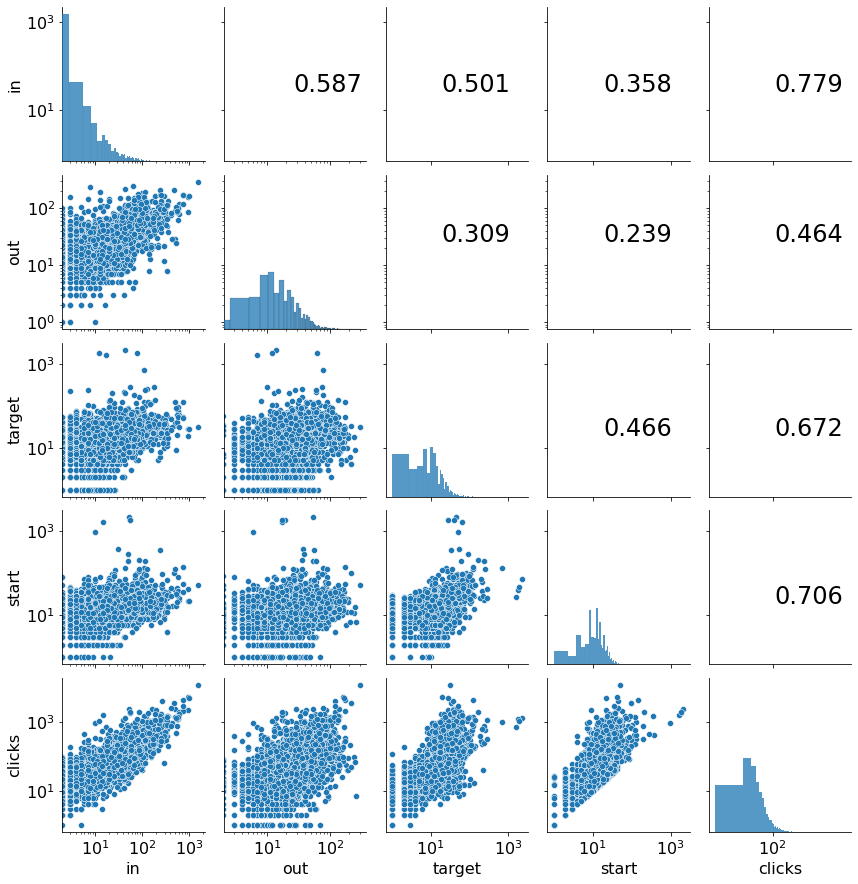

In [78]:
with np.errstate(divide='ignore'):
    corr = np.log(degree_connect).corr()

    
pp = sns.pairplot(degree_connect)

for i in range(5):
    for j in range(i+1,5):
        pp.axes[i,j].clear()
        
        x = degree_connect.iloc[:,j].mean()
        y = degree_connect.iloc[:,i].mean()
        pp.axes[i,j].text(x,y,
                          f"{corr.iloc[i,j]:.3f}", fontsize=24)


for ax in pp.axes.flat:
    ax.set(xscale="log", yscale="log")

# Edge curvature. See [1](https://match.pmf.kg.ac.rs/electronic_versions/Match80/n3/match80n3_605-622.pdf), [2](https://arxiv.org/pdf/1605.04662.pdf), and [3](https://arxiv.org/pdf/1811.07825.pdf).

## Ricci curvature: Associated with tangent vectors.

That is, a direction, so in networks it's assigned to edges (links between articles).

- Ricci curvature is weaker (than sectional curvature), but still surprisingly powerful. It measures the growth of volumes and the coupling properties of random walks

### Two types of Ricci curvature:

- Ollivier:
    Transportation distance between two points 
    Thus considers all possible paths from $x$ to $y$

- Forman:
    Riemmannian: How fast the volume of distanca ball grows.
    In networks: how fast edges spread in different directions -> notion of divergence.
        Edges with very negative curvature should play a special role for spreading out
        *they might turn out to be key for success in game* 
        
        TODO: test hypothesis.
        
   For undirected, unnweighted graphs, Forman-Ricci curvature of edge $e$ is defined:
   
   $Ric(e) = 4 - deg(\nu_1) - deg(\nu_2)$
        
   - $Ric(e) << 0$      if both vertices have high degree
   - $Ric(e) = 0$       if both vertices have degree == 2.
   
   
*Let's stick to Forman-Ricci, for ease of computation and interpretability*.

Empirically, both definitions highly correlate, see [1](https://match.pmf.kg.ac.rs/electronic_versions/Match80/n3/match80n3_605-622.pdf).
        
### Directed graphs.

Define $F(_\rightarrow e_\rightarrow)$ as the curvature related to flow through edge $e$.

\begin{align*}
F(_\rightarrow e_\rightarrow) &= F(_\rightarrow e) + F(e_\rightarrow) \\
F(_\rightarrow e_\rightarrow) &= 2 - in(i) - out(j)
\end{align*}

---

# For this work:

- For edges, we will quantify `flow-through`, i.e. $F(_\rightarrow e_\rightarrow)$.
- For nodes, we will quantify out-degree. This tells the potential to further connect once the node is reached.

---

Can we conclude at some point that `successful strategies are those in which a key article is first reached, and then other articles are reached from there?`.




In [79]:
# Let's calculate curvature for each edge in the graph

# get in-degree(`in`) and out-degree(`out`)
curv_edge = (
    df_links
    .merge(
        (degree_connect[["in"]]
         .rename(columns={"in":"in-degree(src)"})),
        left_on="tgt", 
        right_index=True,
        how="outer")
    .merge(
        (degree_connect[["out"]]
         .rename(columns={"out":"out-degree(tgt)"})),
        left_on="src", 
        right_index=True,
        how="outer")
)

# Calculate curvature
curv_edge["curvature"] = 2 - curv_edge["in-degree(src)"] - curv_edge["out-degree(tgt)"]

curv_edge.sample(5)

,src,tgt,in-degree(src),out-degree(tgt),curvature
119585.0,zimbabwe,copper,156.0,63.0,-217.0
55971.0,ireland,u2,22.0,71.0,-91.0
57412.0,j. r. r. tolkien,walrus,9.0,56.0,-63.0
70431.0,mary ii of england,philip ii of spain,26.0,26.0,-50.0
11810.0,bt tower,company (law),7.0,11.0,-16.0


Text(0.5, 0, 'Node out-degree')

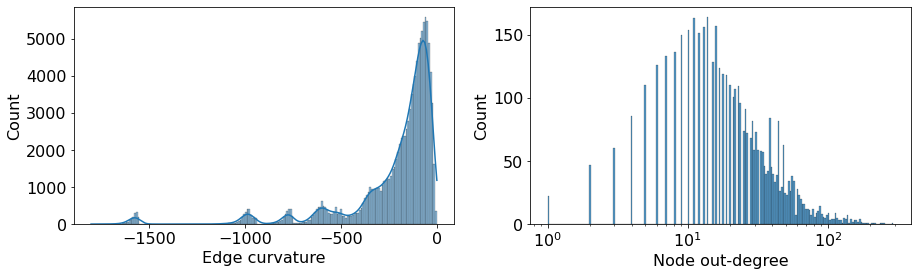

In [80]:
fig, ax = plt.subplots(1,2,figsize=(15, 4))

sns.histplot(data=curv_edge, 
             x="curvature", 
             bins=200, 
             ax=ax[0], 
             kde=True)

sns.histplot(data=degree_connect.query("out!=0"), 
             x="out", 
             bins=200, 
             ax=ax[1], 
             log_scale=True)

ax[0].set_xlabel("Edge curvature")
ax[1].set_xlabel("Node out-degree")

# Interesting.

The distribution of edge curvature seems to be centered around certain values. 
- Why? 
- How are they different? 
- Does this have any relationship with semantics?

# Let's see if paths taken by people provide some insight.

In [81]:
# First get, for every path, a sequence of nodes.

# TODO: Think abt what to do with paths containing `<`

# For convenience, let's drop them for now
df_paths_clean = (df_paths[df_paths["path"]
                           .apply(lambda x: '<' not in x)])

def list_nodes(pathl):
    return [
        [pathl[i],pathl[i+1]]
        for i in range(len(pathl)-1)
    ]
    
# Array to index edge -> curvature 
indx_curva = (curv_edge
              .set_index(["src", "tgt"])
              .loc[:,"curvature"])
def path_curvature(row):
    try:
        return (indx_curva
                .loc[row["edgel"]]
                .values)
    except:
        return []

df_paths_clean["edgel"] = df_paths_clean["pathl"].apply(list_nodes)
df_paths_clean["path_curv"] = df_paths_clean.apply(path_curvature, axis=1)

df_paths_clean.head()

,ip,timestamp,duration,path,rating,target,type,pathl,start,edgel,path_curv
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,african slave trade,win,"[14th century, 15th century, 16th century, pac...",14th century,"[[14th century, 15th century], [15th century, ...","[-129.0, -180.0, -274.0, -335.0, -130.0, -488...."
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,african slave trade,win,"[14th century, europe, africa, atlantic slave ...",14th century,"[[14th century, europe], [europe, africa], [af...","[-962.0, -634.0, -225.0, -63.0]"
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,african slave trade,win,"[14th century, niger, nigeria, british empire,...",14th century,"[[14th century, niger], [niger, nigeria], [nig...","[-94.0, -148.0, -207.0, -245.0, -577.0, -225.0..."
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,greece,win,"[14th century, renaissance, ancient greece, gr...",14th century,"[[14th century, renaissance], [renaissance, an...","[-151.0, -224.0, -309.0]"
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,john f. kennedy,win,"[14th century, italy, roman catholic church, h...",14th century,"[[14th century, italy], [italy, roman catholic...","[-579.0, -331.0, -101.0, -83.0, -250.0, -115.0]"


In [82]:
print(df_paths_clean.shape)
df_paths_clean = df_paths_clean[df_paths_clean["path_curv"].apply(len) > 0]
print(df_paths_clean.shape)

(61997, 11)
(56711, 11)


In [83]:
# plot some paths

# create columns of x values (normalized between 0 and 1)
def x_values_01(path_curv):
    return np.linspace(0,1, len(path_curv))
    
df_paths_clean['x_coord'] = (df_paths_clean['path_curv']
                             .apply(x_values_01))

#sns.lineplot(df_paths_clean['path_curv'].iloc[4])

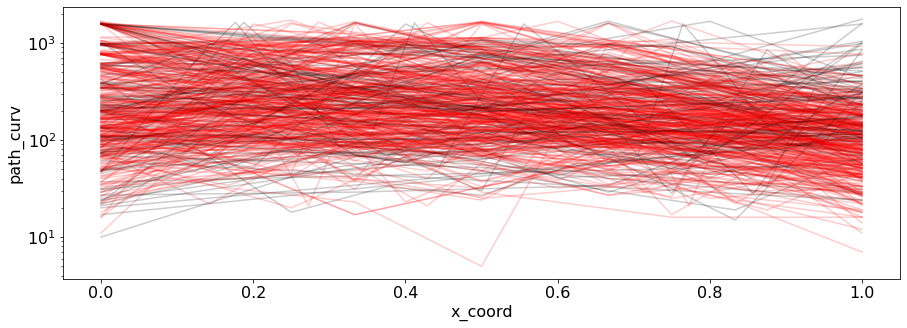

In [84]:
fig, ax = plt.subplots(figsize=(15,5))

M = 500

for i in np.random.permutation(df_paths_clean.shape[0])[:M]:
    if df_paths_clean.iloc[i]["type"] == "win":
        color='r'
    else:
        color='k'
    sns.lineplot(data = np.abs(df_paths_clean.iloc[i][['x_coord','path_curv']]), 
                 x="x_coord", y="path_curv", ax=ax,color=color, alpha=0.2)
    
ax.set_yscale('log')

# Idea:

Analyze paths by measuring the curvature of the nodes it goes through.

- Do successful paths tend to go through highly connected nodes? (we can test this statistically!)

- Can we come up with a different classification? (based on how curvature plot looks like).

TODO: Normalize x axis from 0 to 1, plot a few paths.

---

### Some articles are set as target, but are not in the graph:
Sources are: 
- misspelling (Adolf/Adolph) (Bogota/Bogotá)
- they are just not in the graph

### <font color="red"> This happens only rarely, so we'll remove these cases. </font>

In [ ]:
degree_connect[degree_connect[["in","out"]].isna().any(axis=1)]